# RNA Secondary Structure Prediction Pipelines

This notebook predicts RNA secondary structure in two stages:

- A global structure estimator (GSE) approximates the structure.
- A local structure refiner (LSR) improves the predictions of the GSE.

The pipelines are composed of the following units:

- Global structure estimator (GSE)
- Local structure refiner (LSR)
- Monomialization unit (MU)
- Binarization unit (BU)
- Symmetrization unit (SU)
- Constraint unit (CU)
- Threshold unit (TU)
- Noise removal unit (NRU)
- Output unit: SU -> CU -> MU -> BU -> NRU (OU)

In [4]:
from random import sample

import numpy as np
from torch import optim, nn

from diurnal import database, structure, train, transform, visualize, evaluate, segment, family
from diurnal.models import deep
from diurnal.models.deep import cnn

## Data Preparation

In [5]:
SIZE = 512  # RNA molecule maximum length (longer ones are filtered out).
SUBDIVISION_SIZE = 64  # Kernel size of the local structure refiner.
STRIDE = int(SUBDIVISION_SIZE / 2)

database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-06-15T13:06:20.542227 > INFO Download and install an RNA database.
2024-06-15T13:06:20.570467 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-06-15T13:06:20.572476 > INFO Extract the filenames from the directory `./data/archiveII/`.


100%|██████████| 3975/3975 [00:00<00:00, 13138.57it/s]


2024-06-15T13:06:20.905043 >     Detected 3975 files. Kept 3865 files.
2024-06-15T13:06:20.926518 >     The file `./data/archiveII_processed_512/names.txt` already contains the names.


In [6]:
def format(dst: str, names: list[str]):
    # Primary structures
    pp_scalar = lambda x, y: structure.Primary.to_matrix(
        x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_scalar.npy", SIZE, pp_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    database.format_primary_structure(
        names, f"{dst}primary_onehot.npy",
        SIZE, structure.Primary.to_onehot
    )
    # Secondary structures.
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix
    )

format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-06-15T13:06:23.209863 > INFO Formatting primary structures into `./data/archiveII_processed_512/validation/primary_potential_pairings_scalar.npy`.


2024-06-15T13:06:23.348439 >     The file `./data/archiveII_processed_512/validation/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-15T13:06:23.350441 > INFO Formatting primary structures into `./data/archiveII_processed_512/validation/primary_masks.npy`.
2024-06-15T13:06:23.484140 >     The file `./data/archiveII_processed_512/validation/primary_masks.npy` already contains the formatted data.
2024-06-15T13:06:23.485926 > INFO Formatting primary structures into `./data/archiveII_processed_512/validation/primary_onehot.npy`.
2024-06-15T13:06:23.524483 >     The file `./data/archiveII_processed_512/validation/primary_onehot.npy` already contains the formatted data.
2024-06-15T13:06:23.528020 > INFO Formatting secondary structures into `./data/archiveII_processed_512/validation/secondary_contact.npy`.
2024-06-15T13:06:23.616183 >     The file `./data/archiveII_processed_512/validation/secondary_contact.npy` already contains the formatted data.
2024-06-

In [25]:
def format_data() -> tuple:
    train_set = {
        "input": (np.load(f"{DST}train/primary_potential_pairings_scalar.npy"), ),
        "output": np.load(f"{DST}train/secondary_contact.npy"),
        "mask": np.load(f"{DST}train/primary_masks.npy"),
        "names": []
    }
    validation_set = {
        "input": (np.load(f"{DST}validation/primary_potential_pairings_scalar.npy"), ),
        "output": np.load(f"{DST}validation/secondary_contact.npy"),
        "mask": np.load(f"{DST}validation/primary_masks.npy"),
        "names": []
    }
    test_set = {
        "input": (np.load(f"{DST}test/primary_potential_pairings_scalar.npy"), ),
        "output": np.load(f"{DST}test/secondary_contact.npy"),
        "mask": np.load(f"{DST}test/primary_masks.npy"),
        "names": []
    }
    return train_set, validation_set, test_set


# Create a training set for the LSR.
from os import mkdir
from tqdm import tqdm


def save_global_estimations(model, data, name):
    try:
        mkdir("tmp")
    except:
        pass

    predictions = []
    for i in tqdm(range(len(data["input"][0]))):
        p = model.predict([data["input"][0][i]])
        predictions.append(p)
    np.save(f"tmp/{name}", np.array(predictions))


FIRST = 16  # Select the most important areas.
RANDOM = 8  # Select random areas after the FIRST ones.


def sample_crops(predictions, data, name, maximum, t = 0) -> list:
    predict_crops = []
    pp_crops = []  # Potential pairings
    contact_crops = []
    for index in tqdm(range(len(predictions))):
        prediction = predictions[index] * predictions[index].T * data["mask"][index]
        all_crops = segment.sample_areas(
            prediction, SUBDIVISION_SIZE, stride=STRIDE, threshold=t
        )
        if len(all_crops) > FIRST:
            difference = len(all_crops) - FIRST
            sampling = min(difference, RANDOM)
            if sampling:
                crops = all_crops[:FIRST] + sample(all_crops[FIRST:], sampling)
            else:
                crops = all_crops[:FIRST]
        else:
            crops = all_crops

        for crop, _ in crops:
            predict_crops.append(
                predictions[index][crop[0]: crop[0] + SUBDIVISION_SIZE, crop[1]: crop[1] + SUBDIVISION_SIZE]
            )
            pp_crops.append(
                data["input"][0][index][crop[0]: crop[0] + SUBDIVISION_SIZE, crop[1]: crop[1] + SUBDIVISION_SIZE]
            )
            contact_crops.append(
                data["output"][index][crop[0]: crop[0] + SUBDIVISION_SIZE, crop[1]: crop[1] + SUBDIVISION_SIZE]
            )

        if len(predict_crops) >= maximum:
            break

    np.save(f"tmp/{name}_areas_prediction_{SUBDIVISION_SIZE}.npy", np.array(predict_crops))
    np.save(f"tmp/{name}_areas_pp_{SUBDIVISION_SIZE}.npy", np.array(pp_crops))
    np.save(f"tmp/{name}_areas_contact_{SUBDIVISION_SIZE}.npy", np.array(contact_crops))


def format_refiner_data() -> tuple:
    train_set = {
        "input": (
            np.load(f"tmp/train_areas_prediction_{SUBDIVISION_SIZE}.npy"),
            np.load(f"tmp/train_areas_pp_{SUBDIVISION_SIZE}.npy")
        ),
        "output": np.load(f"tmp/train_areas_contact_{SUBDIVISION_SIZE}.npy"),
        "names": []
    }
    validation_set = {
        "input": (
            np.load(f"tmp/validation_areas_prediction_{SUBDIVISION_SIZE}.npy"),
            np.load(f"tmp/validation_areas_pp_{SUBDIVISION_SIZE}.npy")
        ),
        "output": np.load(f"tmp/validation_areas_contact_{SUBDIVISION_SIZE}.npy"),
        "names": []
    }
    test_set = {
        "input": (
            np.load(f"tmp/test_areas_prediction_{SUBDIVISION_SIZE}.npy"),
            np.load(f"tmp/test_areas_pp_{SUBDIVISION_SIZE}.npy")
        ),
        "output": np.load(f"tmp/test_areas_contact_{SUBDIVISION_SIZE}.npy"),
        "names": []
    }
    return train_set, validation_set, test_set


def refine(estimation: np.ndarray, potential_pairings: np.ndarray, model) -> np.ndarray:
    result = np.zeros((SIZE, SIZE))
    for v_stride in range(int(SIZE / SUBDIVISION_SIZE)):
        row = v_stride * SUBDIVISION_SIZE
        for h_stride in range(int(SIZE / SUBDIVISION_SIZE)):
            column = h_stride * SUBDIVISION_SIZE
            sub_estimation = estimation[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            sub_input = potential_pairings[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            prediction = model.predict([sub_estimation, sub_input])
            result[row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE] = prediction
    return result


def dense_refine(estimation: np.ndarray, potential_pairings: np.ndarray, model) -> np.ndarray:
    result = np.zeros((SIZE, SIZE))
    for v_stride in range(int(SIZE / SUBDIVISION_SIZE) * 2 - 1):
        row = int(v_stride / 2 * SUBDIVISION_SIZE)
        for h_stride in range(int(SIZE / SUBDIVISION_SIZE) * 2 - 1):
            column = int(h_stride /2 * SUBDIVISION_SIZE)
            sub_estimation = estimation[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            sub_input = potential_pairings[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            prediction = model.predict([sub_estimation, sub_input])
            result[row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE] += prediction
    return result / 2

In [23]:
def MU(matrix: np.ndarray) -> np.ndarray:
    return transform.to_monomial_matrix(matrix)


def BU(matrix: np.ndarray) -> np.ndarray:
    return transform.to_binary_matrix(matrix)


def SU(matrix: np.ndarray) -> np.ndarray:
    return matrix * matrix.T


def CU(matrix: np.ndarray, mask: np.ndarray) -> np.ndarray:
    return matrix * mask


def TU(matrix: np.ndarray, threshold: float) -> np.ndarray:
    return (matrix < threshold) * matrix


def NRU(matrix: np.ndarray, threshold: float) -> np.ndarray:
    return segment.convolutional_denoise(matrix, threshold=threshold)


def NU(matrix: np.ndarray) -> np.ndarray:
    normalized = matrix.copy()
    maximum = normalized.max()
    normalized[normalized == 0] = 2
    minimum = normalized.min()
    normalized -= minimum
    normalized *= 1 / (maximum - minimum)
    normalized[normalized > 1] = 0
    return normalized


def OU(matrix: np.ndarray, mask: np.ndarray) -> np.ndarray:
    matrix = CU(matrix, mask)
    matrix = SU(matrix)
    matrix = MU(matrix)
    matrix = BU(matrix)
    matrix = NRU(matrix, 2)
    return matrix

In [21]:
def inspect(model, data: dict, i: int) -> None:
    t = data["output"][i]
    p = model(data["input"][0][i], data["mask"][i])
    visualize.compare_pairings(t, p)
    print(f"F1 score: {evaluate.ContactMatrix.f1(t, p)}")


def measure_performances(model, data) -> list[float]:
    scores = []
    for i in range(len(data["output"])):
        t = data["output"][i]
        p = model(data["input"][0][i], data["mask"][i])
        f = evaluate.ContactMatrix.f1(t, p)
        scores.append(f)
    print(f"F1 scores: {scores}")
    print(f"Arithmetic mean: {np.mean(scores)}")
    return scores

## GSE

In [7]:
train_data, validation_data, test_data = format_data()

def get_GSE(t, v):
    N_MAX_EPOCHS = 100
    GSE = deep.NN(
        model=cnn.UNet2D(SIZE, 4),
        n_epochs=N_MAX_EPOCHS,
        optimizer=optim.Adam,
        loss_fn=nn.CrossEntropyLoss,
        use_half=False,
        patience=10,
        verbosity=2,
    )
    GSE.train(t, v)
    return GSE


GSE = get_GSE(train_data, validation_data)


def model_1(pp: np.ndarray, mask: np.ndarray):
    x = GSE.predict([pp])
    x = OU(x, mask)
    return x

2024-06-14T16:06:33.239295 > INFO Training the model with 3092 data points.
2024-06-14T16:06:33.241507 >     Using 386 data points for validation.
2024-06-14T16:06:33.242566 >     Beginning the training.
2024-06-14T16:07:39.609839 >   0 / 100 [                                                  ] Loss: 1.25490  Patience: 10
2024-06-14T16:07:45.786181 >   1 / 100 [                                                  ] Loss: 1.25548  Patience: 10
2024-06-14T16:07:51.965083 >   2 / 100 [=                                                 ] Loss: 1.25645  Patience: 9
2024-06-14T16:07:58.119829 >   3 / 100 [=                                                 ] Loss: 1.25504  Patience: 8
2024-06-14T16:08:04.253491 >   4 / 100 [==                                                ] Loss: 1.24951  Patience: 8
2024-06-14T16:08:10.404152 >   5 / 100 [==                                                ] Loss: 1.24539  Patience: 8
2024-06-14T16:08:16.593356 >   6 / 100 [===                                     

In [8]:
model_1_results = measure_performances(model_1, test_data)

# No conv: Arithmetic mean: 0.5902806789582146
# Conv: Arithmetic mean: 0.7679855724603966

F1 scores: [0.1666666865348816, 0.22429907321929932, 0.2800000011920929, 0.444444477558136, 0.15172414481639862, 0.18840579688549042, 0.1600000113248825, 0.6626505851745605, 0.6341463327407837, 0.6101694703102112, 0.95652174949646, 0.5750000476837158, 0.7246376872062683, 0.8732393980026245, 0.6666666865348816, 0.4833333492279053, 0.40000003576278687, 0.5614035129547119, 0.6818182468414307, 0.0, 0.19117647409439087, 0.41059601306915283, 0.5200000405311584, 0.8529411554336548, 0.6000000238418579, 0.636363685131073, 0.6461538672447205, 0.05194805562496185, 0.0, 0.6829268336296082, 0.2702702581882477, 0.8405796885490417, 0.6106870770454407, 0.21311475336551666, 0.8275861740112305, 0.8571428656578064, 0.6666666865348816, 0.8571428656578064, 0.7820513248443604, 0.6703296303749084, 0.78125, 0.0875912457704544, 0.75, 0.0, 0.714285671710968, 0.6538461446762085, 0.0, 0.6060606241226196, 0.9705882668495178, 0.30434781312942505, 0.6461538672447205, 0.8055555820465088, 0.9230769276618958, 0.1212121

## LSR

In [9]:
class Estimator:
    def predict(pp) -> np.ndarray:
        estimation = GSE.predict(pp)
        mask = pp[0].copy()
        mask[mask > 0] = 1
        estimation *= mask
        estimation = SU(estimation)
        estimation = NU(estimation)
        return estimation#NRU(estimation, 2)


def save_intermediate(t, v, tt):
    print("Predict global estimations.")
    save_global_estimations(Estimator, t, "train_predictions.npy")
    save_global_estimations(Estimator, v, "validation_predictions.npy")
    save_global_estimations(Estimator, tt, "test_predictions.npy")

    print("Sample subregions from the predictions and input data.")
    sample_crops(np.load("tmp/train_predictions.npy"), t, "train", 100_000)
    sample_crops(np.load("tmp/validation_predictions.npy"), v, "validation", 25_000)
    sample_crops(np.load("tmp/test_predictions.npy"), tt, "test", 25_000)


save_intermediate(train_data, validation_data, test_data)

  0%|          | 0/3092 [00:00<?, ?it/s]

100%|██████████| 386/386 [00:03<00:00, 115.88it/s]


Sample subregions from the predictions and input data.


100%|██████████| 386/386 [00:01<00:00, 318.59it/s]


In [10]:
from torch import nn, cat, stack, squeeze, Tensor, ones_like, log
import torch.nn.functional as F


class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.gamma_p = 0.1
        self.gamma_n = 10
    def forward(self, p, y):
        """
        L: Loss
        y: True structure
        p: Prediction
        Lp: Positive loss (i.e. loss associated to 1 (paired) labels)
        Ln: Negative loss (i.e. loss associated to 0 (unpaired) labels)
        gp: Positive gamme focus parameter
        gn: Negative gamme focus parameter

        L = -y Lp - (1 - y)Ln

        Lp = (1 - p)^gp log(p)
        Ln = p^gn log(1 - p)

        with gn > gp (emphasize the contribution of positive samples).
        """
        Lp = (ones_like(p) - p)**self.gamma_p * log(p)
        Ln = p**self.gamma_n * log(ones_like(p) - p)
        return (-1.0 * y * Lp - (ones_like(p) - y) * Ln).sum()


class UNet2DRefiner(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.convInput = nn.Conv2d(2, 1, 3, padding="same")
        self.conv1 = nn.Conv2d(2, 1, 3, padding="same")
        self.conv2 = nn.Conv2d(1, 1, 3, padding="same")
        # Parameters.
        self.n = n
        self.kernel = 3
        self.activation = F.relu
        self.linear1 = nn.Linear(n, n)
        self.linear2 = nn.Linear(n, n)
        self.linear3 = nn.Linear(n, n)
        self.output = nn.Sigmoid()

    def forward(self, prediction: Tensor, pp: Tensor) -> Tensor:
        # Input processing.
        x1 = stack((prediction, ), dim=1)
        y = stack((pp, ), dim=1)
        z = cat((x1, y), 1)
        x0 = self.convInput(z)
        # Hidden layers
        x = self.linear1(x0)
        x = self.activation(x)
        x1 = self.conv1(cat((x1, x), 1))

        x = self.linear2(x0)
        x = self.activation(x)
        x2 = self.conv1(cat((x, y), 1))
        x = x1 + x2
        x = self.linear3(x)
        x = self.conv2(x)
        # Output
        x = self.output(x)
        x = squeeze(x)
        return x


refiner_train_data, refiner_validation_data, refiner_test_data = format_refiner_data()


def get_LSR(t, v):
    N_MAX_EPOCHS = 100
    LSR = deep.NN(
        model=UNet2DRefiner(SUBDIVISION_SIZE),
        n_epochs=N_MAX_EPOCHS,
        optimizer=optim.Adam,
        loss_fn=CustomLoss,
        loss_fn_args=None,
        use_half=False,
        patience=5,
        verbosity=2,
        batch=256
    )
    LSR.train(t, v)
    return LSR


LSR = get_LSR(refiner_train_data, refiner_validation_data)

2024-06-14T16:13:56.096725 > INFO Training the model with 53308 data points.
2024-06-14T16:13:56.098732 >     Using 6621 data points for validation.
2024-06-14T16:13:56.100731 >     Beginning the training.
2024-06-14T16:14:04.702450 >   0 / 100 [                                                  ] Loss: 2508.78171  Patience: 5
2024-06-14T16:14:07.278308 >   1 / 100 [                                                  ] Loss: 2432.41617  Patience: 5
2024-06-14T16:14:09.799558 >   2 / 100 [=                                                 ] Loss: 2305.99496  Patience: 5
2024-06-14T16:14:12.340253 >   3 / 100 [=                                                 ] Loss: 2258.73663  Patience: 5
2024-06-14T16:14:14.929429 >   4 / 100 [==                                                ] Loss: 2225.83998  Patience: 5
2024-06-14T16:14:17.537030 >   5 / 100 [==                                                ] Loss: 2198.69954  Patience: 5
2024-06-14T16:14:20.176773 >   6 / 100 [===                   

In [11]:
def model_2(pp: np.ndarray, mask: np.ndarray):
    x = GSE.predict([pp])
    x = CU(x, mask)
    x = SU(x)
    x = NU(x)
    x *= dense_refine(x, pp, LSR)
    x = OU(x, mask)
    return x


def model_3(pp: np.ndarray, mask: np.ndarray):
    x = GSE.predict([pp])
    x = CU(x, mask)
    x = SU(x)
    x = NU(x)
    x = dense_refine(x, pp, LSR)
    x = OU(x, mask)
    return x


model_2_results = measure_performances(model_2, test_data)
model_3_results = measure_performances(model_3, test_data)

print("Model 1: ", np.mean(model_1_results))
print("Model 2: ", np.mean(model_2_results))
print("Model 3: ", np.mean(model_3_results))

F1 scores: [0.36923080682754517, 0.20799998939037323, 0.2261904627084732, 0.5474860668182373, 0.0972222238779068, 0.1428571492433548, 0.41791048645973206, 0.7103825807571411, 0.714285671710968, 0.5454545617103577, 0.9444444179534912, 0.7204301953315735, 0.9090909361839294, 0.7605633735656738, 0.9411765336990356, 0.45454543828964233, 0.4313725531101227, 0.18867924809455872, 0.7731958031654358, 0.033898305147886276, 0.18571430444717407, 0.4197530746459961, 0.5555555820465088, 0.9295774698257446, 0.736842155456543, 0.8732393980026245, 0.805555522441864, 0.13592234253883362, 0.0, 0.6829268336296082, 0.20000000298023224, 0.9577464461326599, 0.525547444820404, 0.2276422679424286, 0.8811880946159363, 0.7826087474822998, 0.25, 0.9117646813392639, 0.8447205424308777, 0.6839379072189331, 0.8695651888847351, 0.07874015718698502, 0.95652174949646, 0.09302326291799545, 0.6818182468414307, 0.6428571939468384, 0.01600000075995922, 0.8709678053855896, 0.9090909361839294, 0.26923078298568726, 0.8055555

## Combination

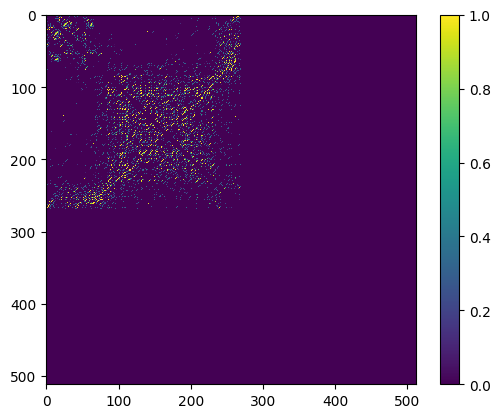

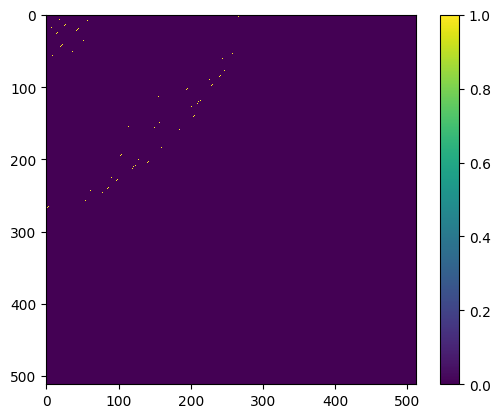

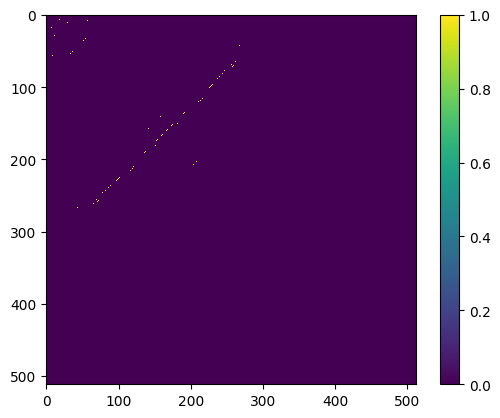

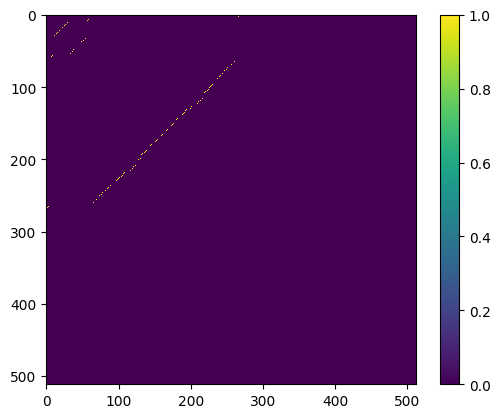

In [15]:
index = 1000

pp = train_data["input"][0][index]
mask = train_data["mask"][index]
real = train_data["output"][index]
estimation = Estimator.predict([pp])

visualize.heatmap(estimation)
visualize.heatmap(model_1(pp, mask))
visualize.heatmap(model_2(pp, mask))
visualize.heatmap(real)

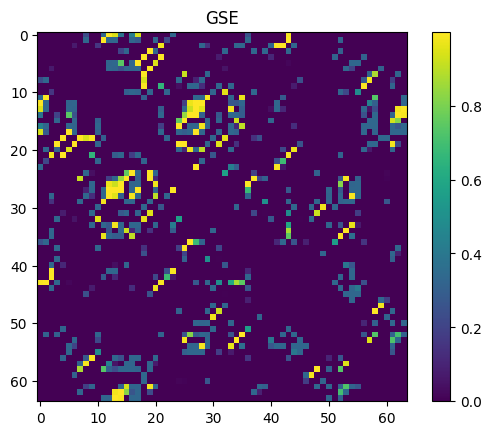

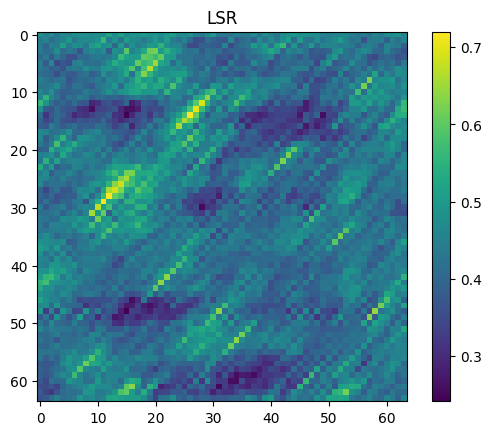

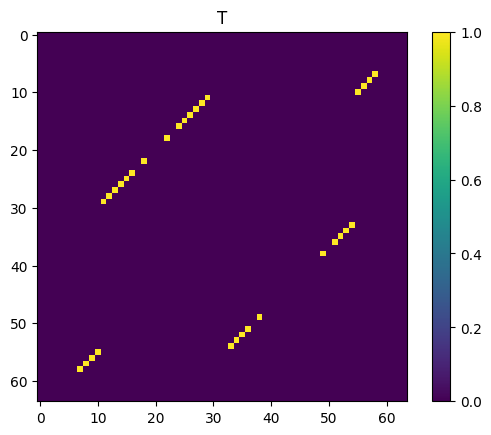

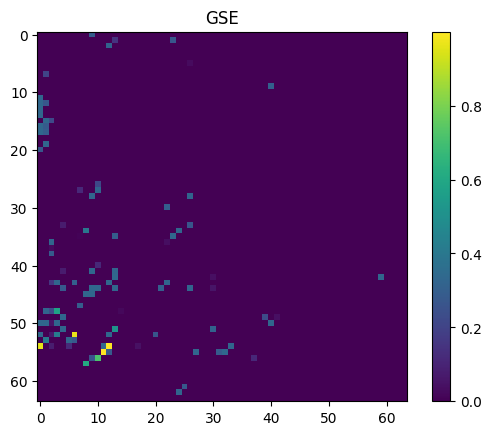

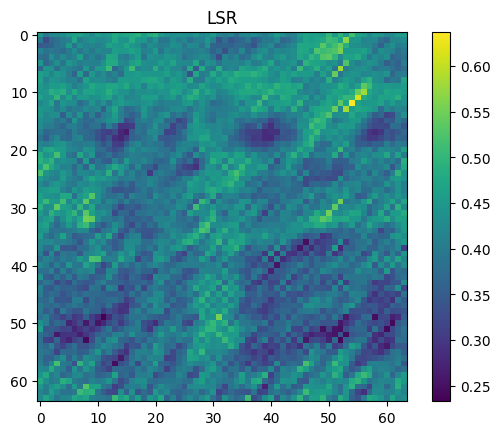

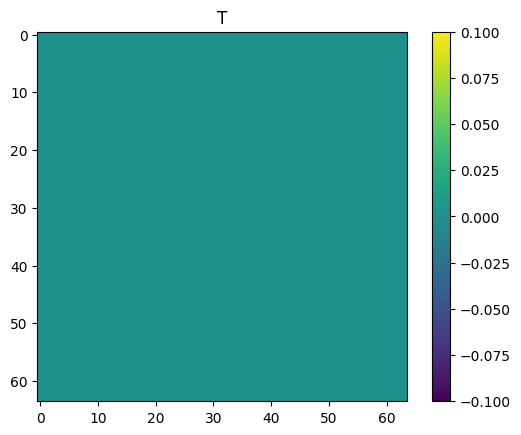

In [16]:
def refine(estimation: np.ndarray, potential_pairings: np.ndarray, refiner) -> np.ndarray:
    result = np.zeros((SIZE, SIZE))
    for v_stride in range(int(SIZE / SUBDIVISION_SIZE)):
        row = v_stride * SUBDIVISION_SIZE
        for h_stride in range(int(SIZE / SUBDIVISION_SIZE)):
            column = h_stride * SUBDIVISION_SIZE
            sub_estimation = estimation[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            sub_input = potential_pairings[
                row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE
            ]
            prediction = refiner.predict([sub_estimation, sub_input])
            result[row:row + SUBDIVISION_SIZE, column:column + SUBDIVISION_SIZE] = prediction
    return result


refined_area = LSR.predict([estimation[:SUBDIVISION_SIZE, :SUBDIVISION_SIZE], pp[:SUBDIVISION_SIZE, :SUBDIVISION_SIZE]])
visualize.heatmap(estimation[:SUBDIVISION_SIZE, :SUBDIVISION_SIZE], "GSE")
visualize.heatmap(refined_area, "LSR")
visualize.heatmap(real[:SUBDIVISION_SIZE, :SUBDIVISION_SIZE], "T")


row, col = 0, 64
refined_area = LSR.predict([estimation[row:row+SUBDIVISION_SIZE, col:col+SUBDIVISION_SIZE], pp[row:row+SUBDIVISION_SIZE, col:col+SUBDIVISION_SIZE]])
visualize.heatmap(estimation[row:row+SUBDIVISION_SIZE, col:col+SUBDIVISION_SIZE], "GSE")
visualize.heatmap(refined_area, "LSR")
visualize.heatmap(real[row:row+SUBDIVISION_SIZE, col:col+SUBDIVISION_SIZE], "T")

## Inter-Family Testing

In [7]:
SIZE = 512  # RNA molecule maximum length (longer ones are filtered out).
SUBDIVISION_SIZE = 64  # Kernel size of the local structure refiner.
STRIDE = int(SUBDIVISION_SIZE / 2)

DATABASE = "archiveII"
database.download("./data/", DATABASE)
SRC = f"./data/{DATABASE}/"  # Input directory containing the CT files.
DST = f"./data/{DATABASE}_families_{SIZE}/"  # Output directory of the formatted files.
names = database.format_filenames(SRC, DST + "names.txt", SIZE)

2024-06-15T13:06:32.138066 > INFO Download and install an RNA database.
2024-06-15T13:06:32.166175 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.
2024-06-15T13:06:32.169708 > INFO Extract the filenames from the directory `./data/archiveII/`.


100%|██████████| 3975/3975 [00:00<00:00, 12083.31it/s]


2024-06-15T13:06:32.564404 >     Detected 3975 files. Kept 3865 files.
2024-06-15T13:06:32.568744 >     The file `./data/archiveII_families_512/names.txt` already contains the names.


In [8]:
families = family.split(names)
for f in families:
    format(f"{DST}{family}/", families[family])

2024-06-15T13:06:34.417996 > INFO Formatting primary structures into `./data/archiveII_families_512/SRP/primary_potential_pairings_scalar.npy`.
2024-06-15T13:06:34.512175 >     The file `./data/archiveII_families_512/SRP/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-15T13:06:34.514773 > INFO Formatting primary structures into `./data/archiveII_families_512/SRP/primary_masks.npy`.
2024-06-15T13:06:34.654403 >     The file `./data/archiveII_families_512/SRP/primary_masks.npy` already contains the formatted data.
2024-06-15T13:06:34.657861 > INFO Formatting primary structures into `./data/archiveII_families_512/SRP/primary_onehot.npy`.
2024-06-15T13:06:34.729473 >     The file `./data/archiveII_families_512/SRP/primary_onehot.npy` already contains the formatted data.
2024-06-15T13:06:34.733332 > INFO Formatting secondary structures into `./data/archiveII_families_512/SRP/secondary_contact.npy`.
2024-06-15T13:06:34.837367 >     The file `./data/archive

In [17]:
def format_data(families: list[str]) -> tuple:
    pp = []
    for f in families:
        try:
            pp_ = np.load(f"{DST}{f}/primary_potential_pairings_scalar.npy")
            pp.append(pp_)
        except:
            pass
    pp = np.concatenate(pp)

    contact = []
    for f in families:
        try:
            contact.append(np.load(f"{DST}{f}/secondary_contact.npy"))
        except:
            pass
    contact = np.concatenate(contact)

    mask = []
    for f in families:
        try:
            mask.append(np.load(f"{DST}{f}/primary_masks.npy"))
        except:
            pass
    mask = np.concatenate(mask)

    return {
        "input": (pp, ),
        "output": contact,
        "mask": mask,
        "names": []
    }

In [ ]:
train_data = format_data(family.all_but("5s"))
test_data = format_data(["5s"])

In [19]:
def get_GSE(t):
    N_MAX_EPOCHS = 50
    GSE = deep.NN(
        model=cnn.UNet2D(SIZE, 4),
        n_epochs=N_MAX_EPOCHS,
        optimizer=optim.Adam,
        loss_fn=nn.CrossEntropyLoss,
        use_half=False,
        patience=10,
        verbosity=2,
    )
    GSE.train(t)
    return GSE


GSE = get_GSE(train_data)


def model_1(pp: np.ndarray, mask: np.ndarray):
    x = GSE.predict([pp])
    x = OU(x, mask)
    return x

2024-06-15T13:35:52.354289 > INFO Training the model with 2582 data points.
2024-06-15T13:35:52.356324 >     Beginning the training.
2024-06-15T13:40:49.430716 >  0 / 50 [                                                  ]>  1 / 50 [=                                                 ]>  2 / 50 [==                                                ]>  3 / 50 [===                                               ]>  4 / 50 [====                                              ]>  5 / 50 [=====                                             ]>  6 / 50 [======                                            ]>  7 / 50 [=======                                           ]>  8 / 50 [========                                          ]>  9 / 50 [=========                                         ]> 10 / 50 [==========                                        ]> 11 / 50 [===========                                       ]> 12 / 50 [============                                      ]> 13 / 50 [=============          

In [24]:
model_1_results = measure_performances(model_1, test_data)

F1 scores: [0.09090909361839294, 0.17777776718139648, 0.0, 0.18867924809455872, 0.08163265883922577, 0.08510638773441315, 0.1428571343421936, 0.27450981736183167, 0.0, 0.19230769574642181, 0.13953489065170288, 0.17777776718139648, 0.0, 0.08695652335882187, 0.0, 0.0, 0.1454545557498932, 0.1454545557498932, 0.0, 0.0, 0.0, 0.0, 0.1599999964237213, 0.0, 0.17777776718139648, 0.2641509473323822, 0.07692307978868484, 0.2666666805744171, 0.0, 0.042553193867206573, 0.08163265883922577, 0.04000000283122063, 0.0, 0.0, 0.0, 0.0, 0.13333334028720856, 0.11538460850715637, 0.0, 0.06896551698446274, 0.0, 0.06896550953388214, 0.0, 0.12000000476837158, 0.1538461595773697, 0.18518517911434174, 0.0, 0.1600000113248825, 0.1860465109348297, 0.0, 0.2545454502105713, 0.0, 0.09090909361839294, 0.07547169923782349, 0.0, 0.0, 0.0, 0.07547170668840408, 0.06779660284519196, 0.07692307978868484, 0.0784313753247261, 0.0, 0.0714285671710968, 0.0, 0.0, 0.0, 0.2181818187236786, 0.13333334028720856, 0.1568627506494522, 

In [27]:
class Estimator:
    def predict(pp) -> np.ndarray:
        estimation = GSE.predict(pp)
        mask = pp[0].copy()
        mask[mask > 0] = 1
        estimation *= mask
        estimation = SU(estimation)
        estimation = NU(estimation)
        return estimation#NRU(estimation, 2)


def save_intermediate(t, tt):
    print("Predict global estimations.")
    save_global_estimations(Estimator, t, "train_predictions.npy")
    save_global_estimations(Estimator, tt, "test_predictions.npy")

    print("Sample subregions from the predictions and input data.")
    sample_crops(np.load("tmp/train_predictions.npy"), t, "train", 100_000)
    sample_crops(np.load("tmp/test_predictions.npy"), tt, "test", 25_000)


save_intermediate(train_data, test_data)

Predict global estimations.


100%|██████████| 1283/1283 [00:10<00:00, 122.47it/s]


Sample subregions from the predictions and input data.


100%|██████████| 1283/1283 [00:04<00:00, 265.17it/s]


In [31]:
def format_refiner_data() -> tuple:
    train_set = {
        "input": (
            np.load(f"tmp/train_areas_prediction_{SUBDIVISION_SIZE}.npy"),
            np.load(f"tmp/train_areas_pp_{SUBDIVISION_SIZE}.npy")
        ),
        "output": np.load(f"tmp/train_areas_contact_{SUBDIVISION_SIZE}.npy"),
        "names": []
    }
    test_set = {
        "input": (
            np.load(f"tmp/test_areas_prediction_{SUBDIVISION_SIZE}.npy"),
            np.load(f"tmp/test_areas_pp_{SUBDIVISION_SIZE}.npy")
        ),
        "output": np.load(f"tmp/test_areas_contact_{SUBDIVISION_SIZE}.npy"),
        "names": []
    }
    return train_set, test_set


from torch import nn, cat, stack, squeeze, Tensor, ones_like, log
import torch.nn.functional as F


class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.gamma_p = 0.1
        self.gamma_n = 10
    def forward(self, p, y):
        """
        L: Loss
        y: True structure
        p: Prediction
        Lp: Positive loss (i.e. loss associated to 1 (paired) labels)
        Ln: Negative loss (i.e. loss associated to 0 (unpaired) labels)
        gp: Positive gamme focus parameter
        gn: Negative gamme focus parameter

        L = -y Lp - (1 - y)Ln

        Lp = (1 - p)^gp log(p)
        Ln = p^gn log(1 - p)

        with gn > gp (emphasize the contribution of positive samples).
        """
        Lp = (ones_like(p) - p)**self.gamma_p * log(p)
        Ln = p**self.gamma_n * log(ones_like(p) - p)
        return (-1.0 * y * Lp - (ones_like(p) - y) * Ln).sum()


class UNet2DRefiner(nn.Module):
    def __init__(self, n: int):
        super().__init__()
        self.convInput = nn.Conv2d(2, 1, 3, padding="same")
        self.conv1 = nn.Conv2d(2, 1, 3, padding="same")
        self.conv2 = nn.Conv2d(1, 1, 3, padding="same")
        # Parameters.
        self.n = n
        self.kernel = 3
        self.activation = F.relu
        self.linear1 = nn.Linear(n, n)
        self.linear2 = nn.Linear(n, n)
        self.linear3 = nn.Linear(n, n)
        self.output = nn.Sigmoid()

    def forward(self, prediction: Tensor, pp: Tensor) -> Tensor:
        # Input processing.
        x1 = stack((prediction, ), dim=1)
        y = stack((pp, ), dim=1)
        z = cat((x1, y), 1)
        x0 = self.convInput(z)
        # Hidden layers
        x = self.linear1(x0)
        x = self.activation(x)
        x1 = self.conv1(cat((x1, x), 1))

        x = self.linear2(x0)
        x = self.activation(x)
        x2 = self.conv1(cat((x, y), 1))
        x = x1 + x2
        x = self.linear3(x)
        x = self.conv2(x)
        # Output
        x = self.output(x)
        x = squeeze(x)
        return x


def get_LSR(t):
    N_MAX_EPOCHS = 100
    LSR = deep.NN(
        model=UNet2DRefiner(SUBDIVISION_SIZE),
        n_epochs=N_MAX_EPOCHS,
        optimizer=optim.Adam,
        loss_fn=CustomLoss,
        loss_fn_args=None,
        use_half=False,
        patience=5,
        verbosity=2,
        batch=256
    )
    LSR.train(t)
    return LSR


refiner_train_data, refiner_test_data = format_refiner_data()
LSR = get_LSR(refiner_train_data)

2024-06-15T13:51:14.025576 > INFO Training the model with 47144 data points.
2024-06-15T13:51:14.028116 >     Beginning the training.
2024-06-15T13:54:44.075070 >   0 / 100 [                                                  ]>   1 / 100 [                                                  ]>   2 / 100 [=                                                 ]>   3 / 100 [=                                                 ]>   4 / 100 [==                                                ]>   5 / 100 [==                                                ]>   6 / 100 [===                                               ]>   7 / 100 [===                                               ]>   8 / 100 [====                                              ]>   9 / 100 [====                                              ]>  10 / 100 [=====                                             ]>  11 / 100 [=====                                             ]>  12 / 100 [======                                            ]>  13 /

In [32]:
def model_2(pp: np.ndarray, mask: np.ndarray):
    x = GSE.predict([pp])
    x = CU(x, mask)
    x = SU(x)
    x = NU(x)
    x *= dense_refine(x, pp, LSR)
    x = OU(x, mask)
    return x


def model_3(pp: np.ndarray, mask: np.ndarray):
    x = GSE.predict([pp])
    x = CU(x, mask)
    x = SU(x)
    x = NU(x)
    x = dense_refine(x, pp, LSR)
    x = OU(x, mask)
    return x


model_2_results = measure_performances(model_2, test_data)
model_3_results = measure_performances(model_3, test_data)

print("Model 1: ", np.mean(model_1_results))
print("Model 2: ", np.mean(model_2_results))
print("Model 3: ", np.mean(model_3_results))

F1 scores: [0.0, 0.30000001192092896, 0.0, 0.11538461595773697, 0.10526316612958908, 0.23880597949028015, 0.0, 0.1249999850988388, 0.0, 0.12765958905220032, 0.1304347962141037, 0.0784313753247261, 0.0, 0.0, 0.07999999821186066, 0.0, 0.07547169923782349, 0.04444444179534912, 0.06557376682758331, 0.0, 0.0, 0.0, 0.0833333358168602, 0.07407407462596893, 0.30000001192092896, 0.03921568766236305, 0.0, 0.0, 0.0, 0.0, 0.13636364042758942, 0.2545454502105713, 0.0, 0.16326530277729034, 0.0, 0.035087719559669495, 0.145454540848732, 0.0, 0.0, 0.0, 0.0, 0.07547169923782349, 0.0, 0.0, 0.0, 0.08510638773441315, 0.10526315122842789, 0.12903225421905518, 0.1568627506494522, 0.06666666269302368, 0.0, 0.0416666679084301, 0.0, 0.0, 0.08510638773441315, 0.0, 0.1886792629957199, 0.0, 0.111111119389534, 0.0, 0.06779661029577255, 0.0357142873108387, 0.07547169923782349, 0.0, 0.0, 0.07017544656991959, 0.16129031777381897, 0.07017543911933899, 0.2448979616165161, 0.0, 0.0, 0.1599999964237213, 0.0, 0.0, 0.0, 0.0

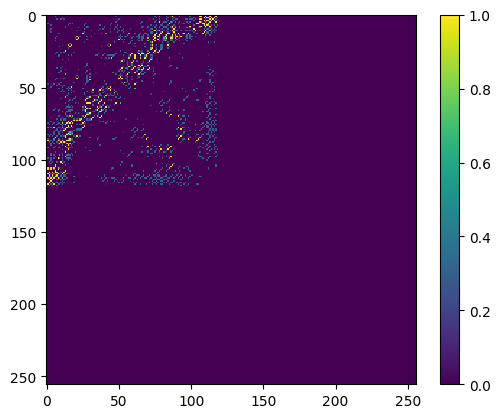

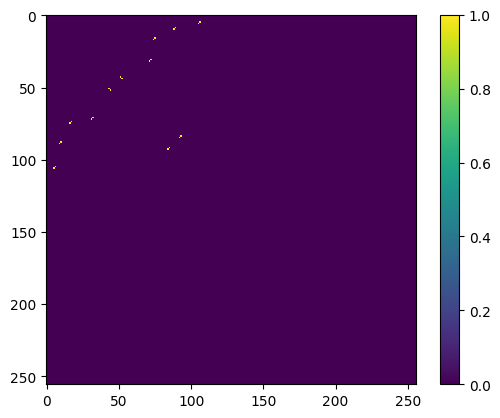

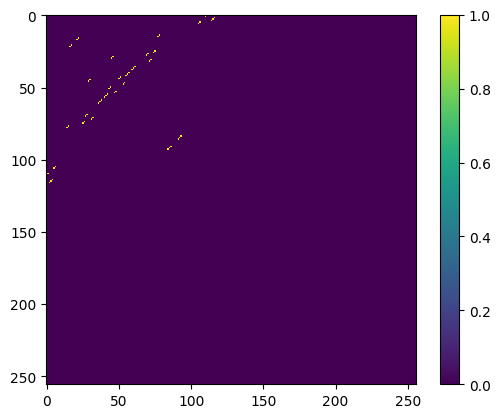

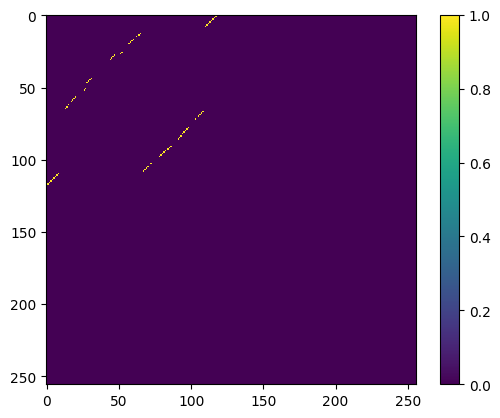

In [38]:
index = 5

pp =   test_data["input"][0][index]
mask = test_data["mask"][index]
real = test_data["output"][index]
estimation = Estimator.predict([pp])

visualize.heatmap(estimation[:256, :256])
visualize.heatmap(model_1(pp, mask)[:256, :256])
visualize.heatmap(model_2(pp, mask)[:256, :256])
visualize.heatmap(real[:256, :256])